In [79]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
from time import time
import lightgbm as lgbm
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

In [80]:
data0=pd.read_csv("C:/Skola/Examensarbete/footballData.csv")
target_variable = 'value_eur'

from sklearn.preprocessing import LabelEncoder
def labelencoder(df):
    for c in df.columns:
        if df[c].dtype=='object': 
            df[c] = df[c].fillna('N')
            lbl = LabelEncoder()
            lbl.fit(list(df[c].values))
            df[c] = lbl.transform(df[c].values)
    return df

In [81]:
# Lista med de positioner som inte syns i dokumentet
positions_to_drop = ['ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 
                     'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 
                     'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb']

# Ta bort de angivna kolumnerna från datamängden
data0 = data0.drop(positions_to_drop, axis=1)


In [82]:
# Mapping dictionary from specific positions to abstract terms
position_mapping = {
    'RW': 'F', 'ST': 'F', 'CF': 'F', 'LW': 'F', 'RF': 'F', 'LF': 'F', 'LS': 'F', 'RS': 'F', 
    'CAM': 'M', 'CM': 'M', 'CDM': 'M', 'LM': 'M', 'RM': 'M', 'LCM': 'M', 'RCM': 'M',
    'LAM': 'M', 'RAM': 'M', 'LDM': 'M', 'RDM': 'M',
    'LB': 'D', 'CB': 'D', 'RB': 'D', 'LWB': 'D', 'RWB': 'D', 'LCB': 'D', 'RCB': 'D',
    'GK': 'GK', 'SUB': 'SUB', 'nan': 'nan', 'RES': 'RES',
}

unique_positions = data0['player_positions'].str.split(', ').explode().unique()
print(unique_positions)

# Apply the mapping to the 'player_positions' column
data0['player_positions'] = data0['player_positions'].str.split(', ').apply(lambda x: ', '.join([position_mapping[pos] for pos in x]))
data0['team_position'] = data0['team_position'].apply(lambda x: ', '.join([position_mapping[pos] for pos in x.split(', ')]) if isinstance(x, str) else x)
data0['nation_position'] = data0['nation_position'].apply(lambda x: ', '.join([position_mapping[pos] for pos in x.split(', ')]) if isinstance(x, str) else x)


# Print unique values of the abstract positions
unique_player_positions = data0['player_positions'].unique()
unique_team_positions = data0['nation_position'].unique()
unique_nation_positions = data0['team_position'].unique()
print(unique_player_positions)
print(unique_team_positions)
print(unique_nation_positions)


['RW' 'ST' 'CF' 'LW' 'GK' 'CAM' 'CM' 'CB' 'CDM' 'RB' 'RM' 'LM' 'LB' 'RWB'
 'LWB']
['F, F, F' 'F, F' 'GK' 'F' 'F, M' 'M, M' 'D' 'M' 'M, D' 'M, M, M'
 'F, M, M' 'M, F' 'M, F, F' 'M, M, F' 'D, M' 'F, F, M' 'M, M, D' 'M, D, M'
 'D, D' 'M, F, M' 'F, M, F' 'D, M, M' 'D, M, D' 'D, D, D' 'D, M, F'
 'M, D, D' 'D, D, M' 'F, D' 'D, F' 'F, D, M' 'M, F, D' 'M, D, F' 'F, D, F'
 'D, F, D' 'F, M, D' 'F, D, D' 'D, F, M' 'F, F, D' 'D, F, F' 'D, D, F'
 'GK, D']
['F' 'GK' nan 'M' 'SUB' 'D']
['M' 'F' 'GK' 'D' 'SUB' 'RES' nan]


In [83]:
#Hanterar strängar i columnerna
#Möjlighet att använda Allsvenska data

# Filter data for Swedish Allsvenskan
swedish_allsvenskan_data = data0[data0['league_name'] == 'Swedish Allsvenskan']
# Filter data for Norwegian Eliteserien
norwegian_eliteserien_data = data0[data0['league_name'] == 'Norwegian Eliteserien']
# Concatenate data for all leagues
all_leagues_data = pd.concat([swedish_allsvenskan_data, norwegian_eliteserien_data], ignore_index=True)

#data1=labelencoder(swedish_allsvenskan_data)
data1 = labelencoder(data0)
m=len(data1)
M=list(range(m))
random.seed(2021)
random.shuffle(M)

df_columns = list(data1.columns)
print(df_columns)

['sofifa_id', 'player_url', 'short_name', 'long_name', 'age', 'dob', 'height_cm', 'weight_kg', 'nationality', 'club_name', 'league_name', 'league_rank', 'overall', 'potential', 'value_eur', 'wage_eur', 'player_positions', 'preferred_foot', 'international_reputation', 'weak_foot', 'skill_moves', 'work_rate', 'body_type', 'real_face', 'release_clause_eur', 'player_tags', 'team_position', 'team_jersey_number', 'loaned_from', 'joined', 'contract_valid_until', 'nation_position', 'nation_jersey_number', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed', 'gk_positioning', 'player_traits', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_ba

In [84]:
#Metod för att skapa numeriska features
def create_numeric_feature(input_df):
    use_columns = df_columns 
    return input_df[use_columns].copy()

In [85]:
from tqdm import tqdm

#Gör om samtliga celler till numeriska värden
def to_feature(input_df):
    processors = [
        create_numeric_feature,
    ]
    out_df = pd.DataFrame()
    
    for func in tqdm(processors, total=len(processors)):
        _df = func(input_df)
        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

data = to_feature(data1)
#Räknar antal celler med tomma värden eller NaN
print(data.isnull().sum())
data.head()

100%|██████████| 1/1 [00:00<00:00, 86.65it/s]

sofifa_id                  0
player_url                 0
short_name                 0
long_name                  0
age                        0
                          ..
goalkeeping_diving         0
goalkeeping_handling       0
goalkeeping_kicking        0
goalkeeping_positioning    0
goalkeeping_reflexes       0
Length: 80, dtype: int64


,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club_name,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,158023,270,10110,10345,33,4804,170,72,6,214,...,75,96,NaN,35,24,6,11,15,14,8
1,20801,4337,3286,3338,35,871,187,83,123,339,...,84,95,NaN,32,24,7,11,15,14,11
2,200389,3029,8128,7613,27,1280,188,87,137,64,...,11,68,NaN,12,18,87,92,78,90,90
3,188545,1631,14414,14732,31,4236,184,80,122,216,...,88,88,NaN,42,19,15,6,12,8,10
4,190871,1978,13069,13009,28,877,175,68,20,452,...,92,93,NaN,30,29,9,9,15,15,11


In [86]:
#Antal tomma celler i varje column
nans=pd.isnull(data).sum()
nans[nans>0]

league_rank               225
release_clause_eur        995
team_jersey_number        225
contract_valid_until      225
nation_jersey_number    17817
pace                     2083
shooting                 2083
passing                  2083
dribbling                2083
defending                2083
physic                   2083
gk_diving               16861
gk_handling             16861
gk_kicking              16861
gk_reflexes             16861
gk_speed                16861
gk_positioning          16861
defending_marking       18944
dtype: int64

In [87]:
#Tar ej med tomma eller nästan helt tomma columner
data = data.drop(["nation_jersey_number", "defending_marking"], axis=1)
data.dtypes.value_counts()


int64      44
int32      18
float64    16
Name: count, dtype: int64

In [88]:
from sklearn.impute import SimpleImputer

#Preprocessing
#Hantera tomma celler
imputer = SimpleImputer(strategy='mean')
data_filled = imputer.fit_transform(data)
data_filled = pd.DataFrame(data_filled, columns=data.columns)

#Logaritmera data för att minska variansen mot målvariabeln 'value_eur'
sample = ['potential', 'league_rank', 'overall', 'skill_moves', 'team_position', 'international_reputation', 'passing', 'movement_reactions', 'age']
#sample = data_filled.drop([target_variable], axis=1)
for col in sample:
    data_filled[col] = np.log1p(data_filled[col])  #np.log1p för att hantera 0 samt negativa logaritmen

train = data_filled.iloc[M[0:(m//4)*3]]
test = data_filled.iloc[M[(m//4)*3:]]

target_variable = 'value_eur'
y_train = train[target_variable]
#X_train = train.drop([target_variable], axis=1)
X_train = train[sample]

y_test = test[target_variable]
#X_test = test.drop([target_variable], axis=1)
X_test = test[sample]

print("Shapes of X_train, y_train, X_test, y_test:")
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Shapes of X_train, y_train, X_test, y_test:
(14208, 9) (14208,) (4736, 9) (4736,)


In [89]:
#PCA Dimension
pca = PCA(whiten=True)
pca.fit(X_train)
variance = pd.DataFrame(pca.explained_variance_ratio_)
np.cumsum(pca.explained_variance_ratio_)

array([0.66913665, 0.79016398, 0.87175843, 0.92863444, 0.95840573,
       0.97908219, 0.99502526, 0.99921673, 1.        ])

In [90]:
train_data = lgbm.Dataset(X_train, label=y_train.values.ravel())  
eval_data = lgbm.Dataset(X_test, label=y_test.values.ravel(), reference=train_data) 

# Längden av x och y träningsdata
print('Train data x length: ', len(train_data.data))
print('Train data y length: ', len(train_data.label))

# Längden av x och y test data
print('Test data x length: ', len(eval_data.data))
print('Test data y length: ', len(eval_data.label))

Train data x length:  14208
Train data y length:  14208
Test data x length:  4736
Test data y length:  4736


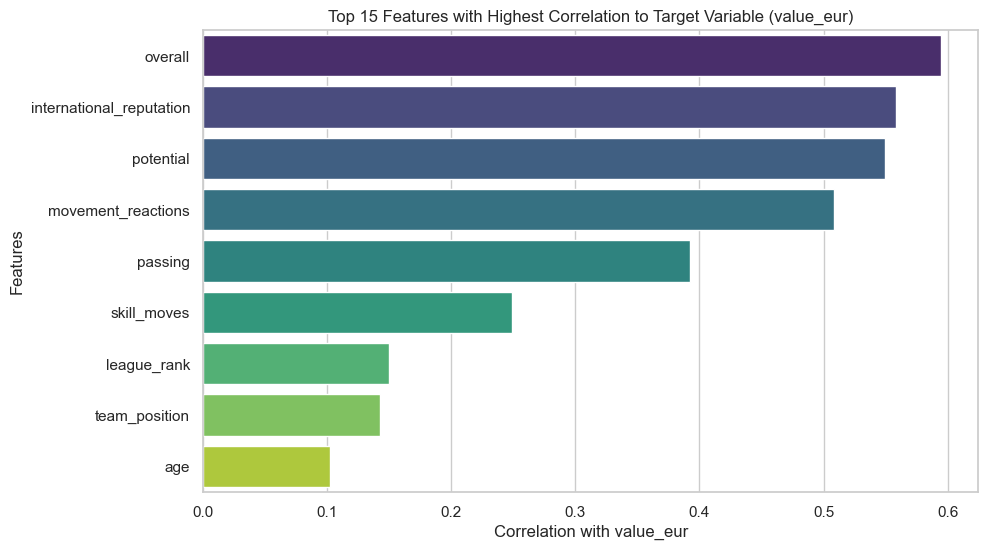

In [91]:
#Antal features som visas
top_n_features = 15

#feature_target_correlation = train.corr()['value_eur'].drop('value_eur')
feature_target_correlation = train[sample + ['value_eur']].corr()['value_eur'].drop('value_eur')
sorted_correlation = feature_target_correlation.abs().nlargest(top_n_features)

plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_correlation.values, y=sorted_correlation.index, palette='viridis')
plt.xlabel('Correlation with value_eur')
plt.ylabel('Features')
plt.title(f'Top {top_n_features} Features with Highest Correlation to Target Variable (value_eur)')
plt.show()

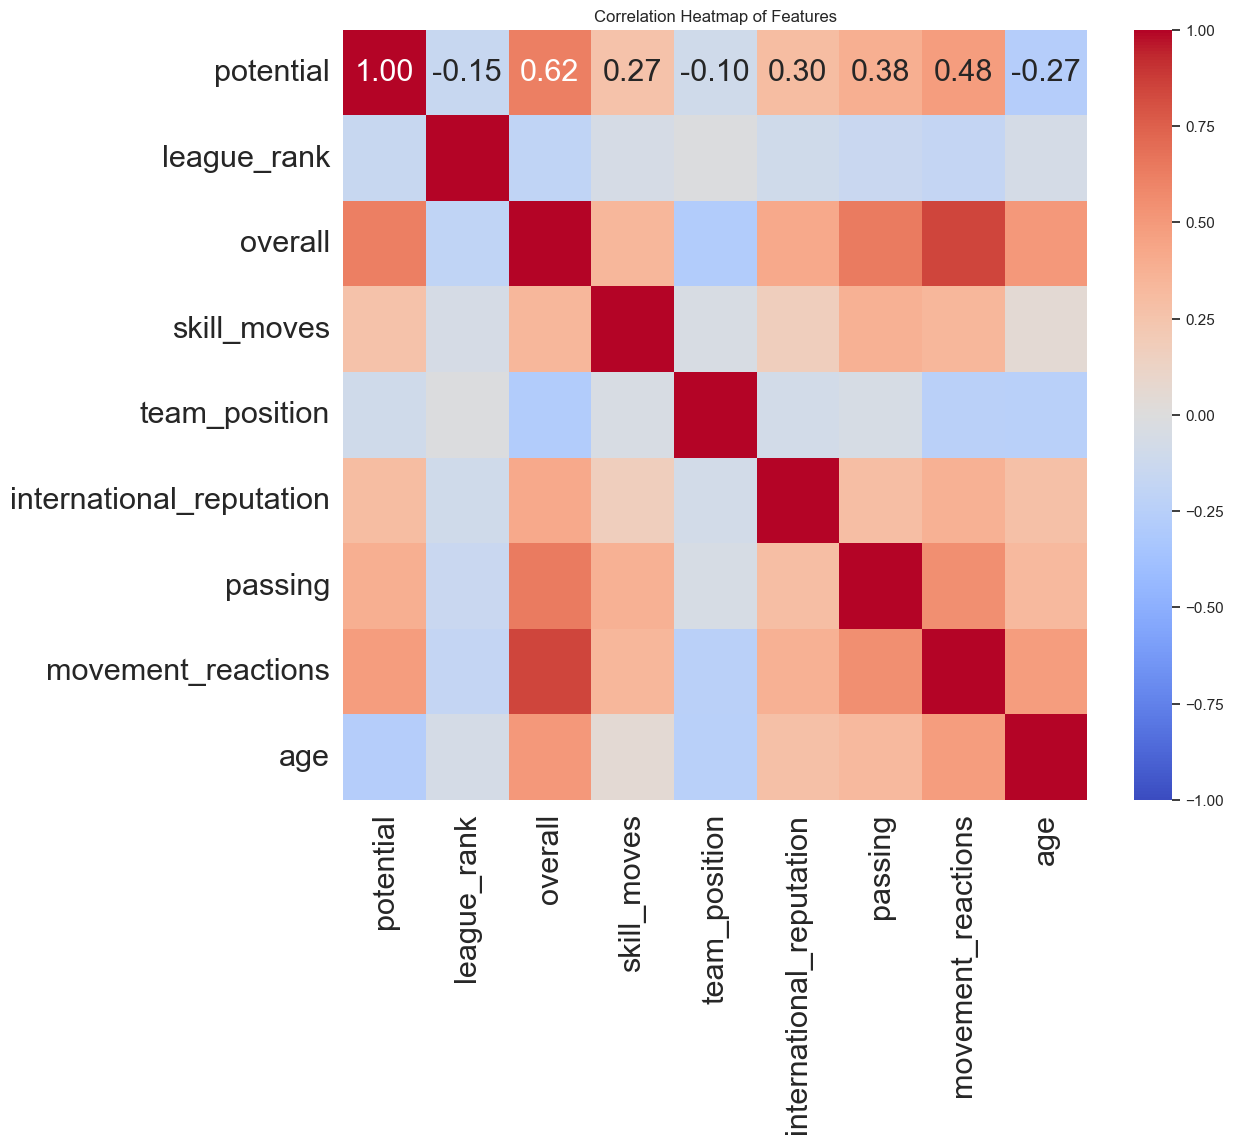

In [92]:
#Pearson Correlation
correlation_matrix = X_train.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, annot_kws={"size": 22})
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=22)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=22)
plt.title('Correlation Heatmap of Features')
plt.show()

In [93]:
#GridSearchCV

from sklearn.pipeline import Pipeline
params = {
    'max_depth': [6, 8, 10],
    'learning_rate': [0.1, 0.20, 0.25],
    'boosting_type' : ['gbdt'],
    'reg_lambda': [0.1, 1, 1.5], 
    'reg_alpha': [0.1, 1.0],   
    'n_estimators': [1000],
    'subsample': [0.9],
    'colsample_bytree': [0.5],
    'verbosity' : [-1]
}

lgb_reg = lgbm.LGBMRegressor()
grid_search = GridSearchCV(estimator=lgb_reg, param_grid=params, scoring='neg_mean_squared_error', cv=5, verbose=3)

grid_search.fit(X_train, y_train)

best_params_lgb = grid_search.best_params_
print("Best parameters:", best_params_lgb)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END boosting_type=gbdt, colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9, verbosity=-1;, score=-324152989906.566 total time=   0.3s
[CV 2/5] END boosting_type=gbdt, colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9, verbosity=-1;, score=-402493331410.994 total time=   0.2s
[CV 3/5] END boosting_type=gbdt, colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9, verbosity=-1;, score=-507604780503.743 total time=   0.2s
[CV 4/5] END boosting_type=gbdt, colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9, verbosity=-1;, score=-343133623002.595 total time=   0.2s
[CV 5/5] END boosting_type=gbdt, colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimator

In [94]:
import sklearn
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

#GridCVSearch
pipeline = Pipeline([
    ('model', XGBRegressor()) 
])

params = { 
    'model__max_depth': [6, 8, 10],
    'model__learning_rate': [0.1, 0.20, 0.25, 0.30],
    "model__gamma":[0, 0.25, 0.5],
    'model__n_estimators': [1000],
    "model__subsample":[0.9],
    "model__colsample_bytree":[0.5],
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid = params,
    scoring = 'neg_root_mean_squared_error',
    n_jobs = -1,
    cv = 5,
    verbose = 3,
)

# Model fitting
grid = grid.fit(X_train, y_train, model__eval_set=[(X_test, y_test)])

# Get the best parameters
best_params = grid.best_params_
print("Best parameters:", best_params)

# Calculate evaluation metric
eval_rmse = sklearn.metrics.mean_squared_error(y_test, grid.best_estimator_.predict(X_test), squared=False)
print("Best RMSE score:", eval_rmse)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[0]	validation_0-rmse:4737229.32630
[1]	validation_0-rmse:4338736.26352
[2]	validation_0-rmse:4137052.01472
[3]	validation_0-rmse:3957375.51835
[4]	validation_0-rmse:3688381.49510
[5]	validation_0-rmse:3379637.22126
[6]	validation_0-rmse:3114998.51077
[7]	validation_0-rmse:2884714.48508
[8]	validation_0-rmse:2678046.70868
[9]	validation_0-rmse:2499405.91200
[10]	validation_0-rmse:2330411.38763
[11]	validation_0-rmse:2260862.61827
[12]	validation_0-rmse:2107407.32845
[13]	validation_0-rmse:1988083.63745
[14]	validation_0-rmse:1934315.93911
[15]	validation_0-rmse:1805454.34304
[16]	validation_0-rmse:1716862.89903
[17]	validation_0-rmse:1612345.19846
[18]	validation_0-rmse:1520822.07170
[19]	validation_0-rmse:1455016.56399
[20]	validation_0-rmse:1394023.41310
[21]	validation_0-rmse:1336563.32573
[22]	validation_0-rmse:1283703.99665
[23]	validation_0-rmse:1266032.53522
[24]	validation_0-rmse:1236483.57359
[25]	validation_0-rmse:

c:\Users\willi\anaconda3\envs\marketValuePrediction\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE:  744788.4456245817
R² score:  0.9793547379629438
MAE:  146653.64855197578


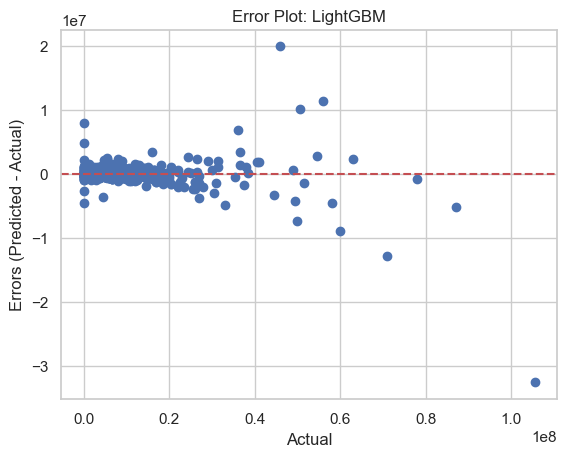

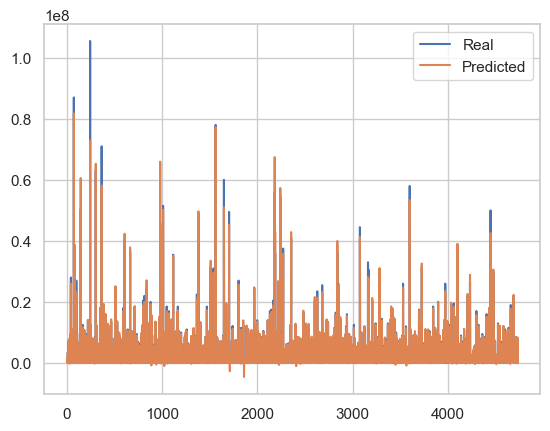

In [101]:
import seaborn as sns

# LightGBM model
model = lgbm.train(best_params_lgb, train_data, valid_sets=[eval_data], num_boost_round=500)    
y_pred_loaded = model.predict(X_test, num_iteration=model.best_iteration)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_loaded))
# R² score
r2 = r2_score(y_test, y_pred_loaded)
mae = mean_absolute_error(y_test, y_pred_loaded)

print('RMSE: ', rmse)
print('R² score: ', r2)
print('MAE: ', mae)

# Calculate errors
errors = y_pred_loaded - y_test.values.ravel()

# Scatter plot of errors
plt.scatter(y_test.values.ravel(), errors)
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.xlabel('Actual')
plt.ylabel('Errors (Predicted - Actual)')
plt.title('Error Plot: LightGBM')
plt.show()

# Plotting actual vs predicted
plt.plot(y_test.values.ravel(), label='Real')
plt.plot(y_pred_loaded, label='Predicted')
plt.legend()
plt.show()

# Save the new model
# model.save_model('lightGBM_model.txt')


c:\Users\willi\anaconda3\envs\marketValuePrediction\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.481e+16, tolerance: 3.447e+13
  model = cd_fast.enet_coordinate_descent(
c:\Users\willi\anaconda3\envs\marketValuePrediction\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.355e+16, tolerance: 3.351e+13
  model = cd_fast.enet_coordinate_descent(
c:\Users\willi\anaconda3\envs\marketValuePrediction\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the

Best parameters: {'alpha': 10, 'fit_intercept': True}
RMSE:  3707327.3567853067
R² score:  0.48846375614478943
MAE:  1854736.3347907313


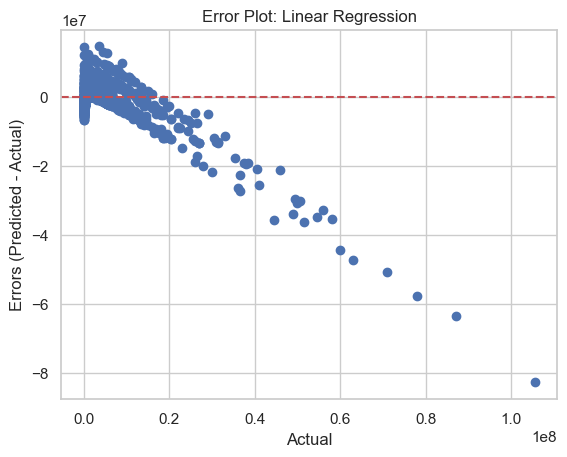

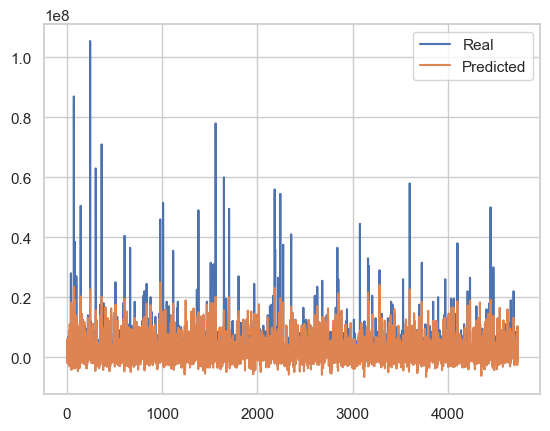

In [102]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

#Linjär regression
lasso_model = Lasso(max_iter=10000)

param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10],  # Regularization strength
              'fit_intercept': [True, False]}

grid_search = GridSearchCV(lasso_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)
y_pred_test = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)

print('RMSE: ', rmse)
print('R² score: ', r2)
print('MAE: ', mae)

errors = y_pred_test - y_test.values.ravel()

# Scatter plot of errors
plt.scatter(y_test.values.ravel(), errors)
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.xlabel('Actual')
plt.ylabel('Errors (Predicted - Actual)')
plt.title('Error Plot: Linear Regression')
plt.show()

# Plot real and predicted values
plt.plot(y_test.values.ravel(), label='Real')
plt.plot(y_pred_test, label='Predicted')
plt.legend()
plt.show()


RMSE:  688761.9323850595
R² score:  0.9823439800848676
MAE:  138450.30937701304


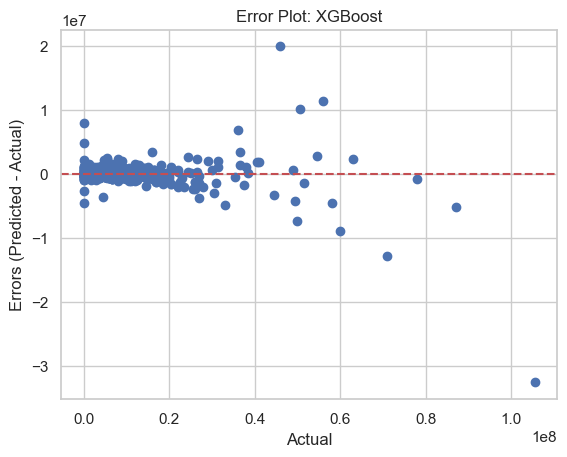

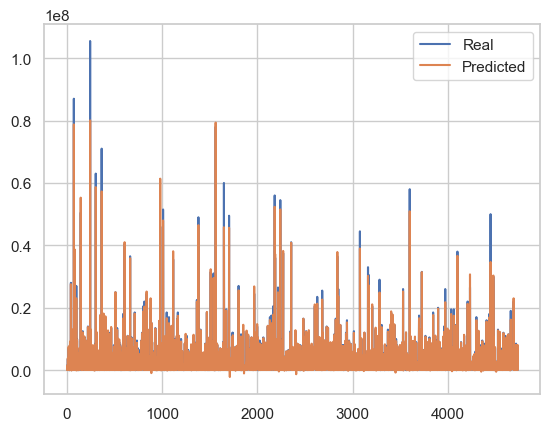

In [103]:
xgb_params = {
    'max_depth': best_params['model__max_depth'],
    'learning_rate': best_params['model__learning_rate'],
    'gamma': best_params['model__gamma'],
    'n_estimators': best_params['model__n_estimators'],
    'subsample': best_params['model__subsample'],
    'colsample_bytree': best_params['model__colsample_bytree']
}

# Create and train the XGBRegressor model with the extracted parameters
xgb_r = xgb.XGBRegressor(**xgb_params)
xgb_r.fit(X_train, y_train) 

# Make predictions
y_pred_test = xgb_r.predict(X_test)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)

# Print evaluation metrics
print('RMSE: ', rmse)
print('R² score: ', r2)
print('MAE: ', mae)

errors = y_pred_loaded - y_test.values.ravel()

# Scatter plot of errors
plt.scatter(y_test.values.ravel(), errors)
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.xlabel('Actual')
plt.ylabel('Errors (Predicted - Actual)')
plt.title('Error Plot: XGBoost')
plt.show()


# Plot real vs predicted values
plt.plot(y_test.values.ravel(), label='Real')
plt.plot(y_pred_test, label='Predicted')
plt.legend()
plt.show()